In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from utils import *
import warnings
warnings.filterwarnings("ignore")

## Recopilación de datos

In [24]:
data =  pd.read_csv('/workspaces/Gupir11-machine-learning/data/raw/sales.csv')
data

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


## Procesamiento de datos

In [25]:
data["date"] 

0      2022-09-03 17:10:08.079328
1      2022-09-04 17:10:08.079328
2      2022-09-05 17:10:08.079328
3      2022-09-06 17:10:08.079328
4      2022-09-07 17:10:08.079328
                  ...            
361    2023-08-30 17:10:08.079328
362    2023-08-31 17:10:08.079328
363    2023-09-01 17:10:08.079328
364    2023-09-02 17:10:08.079328
365    2023-09-03 17:10:08.079328
Name: date, Length: 366, dtype: object

In [26]:
data["date"] = pd.to_datetime(data["date"]).dt.normalize()
data = data.set_index("date")


In [27]:
ts = data["sales"]
ts.head()

date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Name: sales, dtype: float64

## Visualizacion

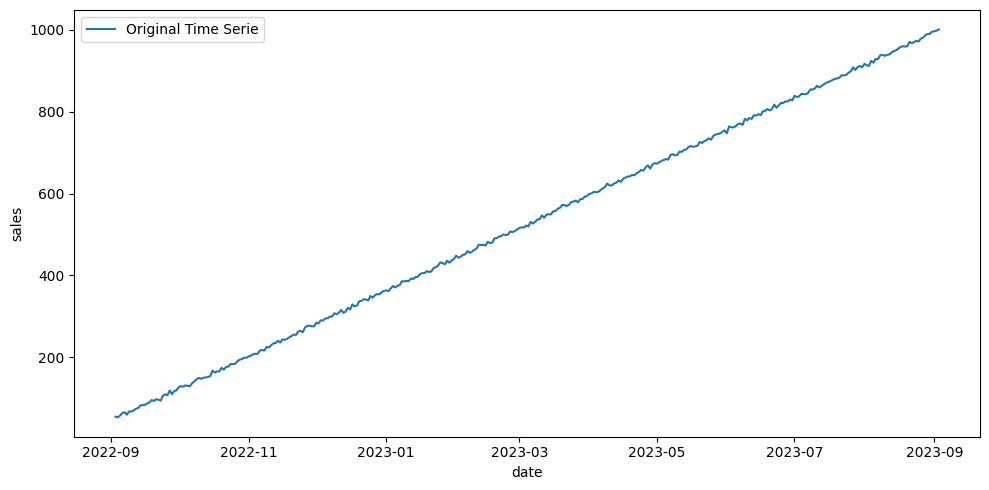

In [28]:
fig, axis = plt.subplots(figsize=(10, 5))
sns.lineplot(data=ts, label="Original Time Serie")

plt.tight_layout()
plt.show()

Se ve una línea creciendo casi perfecta: las ventas suben constantemente con un poquito de ruido. Es una tendencia totalmente ascendente

## Análisis de una serie temporal

In [29]:
decomposition = seasonal_decompose(ts)
decomposition

## Análisis de la tendencia

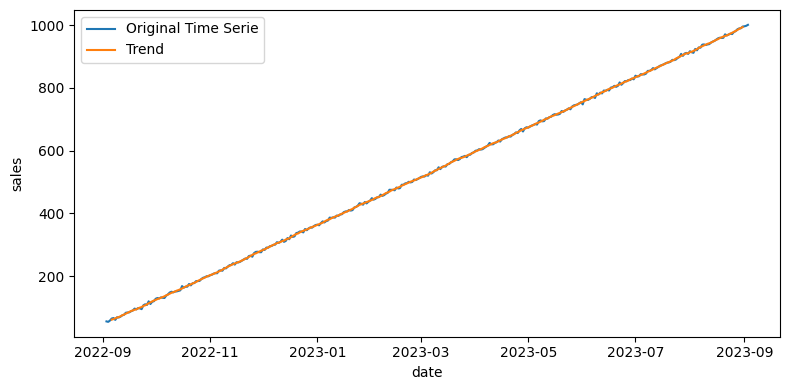

In [30]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize=(8, 4))
sns.lineplot(data=ts, label="Original Time Serie")
sns.lineplot(data=trend, label="Trend")

plt.tight_layout()
plt.show()

Ambas líneas prácticamente se montan una sobre la otra, lo que confirma que la serie es casi totalmente lineal. No hay cambios bruscos, solo crecimiento suave y continuo.

 ## Análisis de la estacionalidad

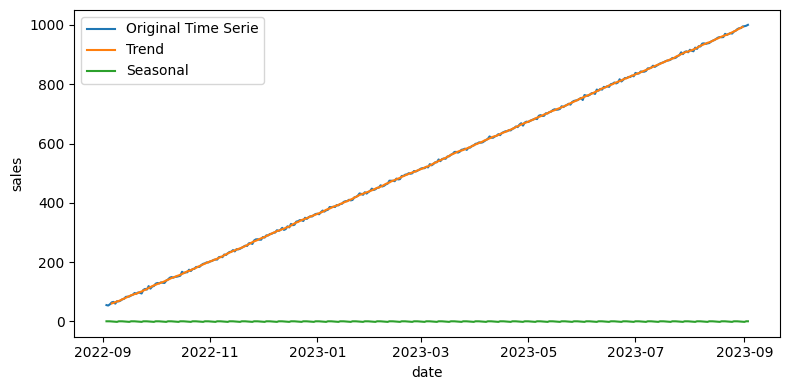

In [31]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize=(8, 4))
sns.lineplot(data=ts, label="Original Time Serie")
sns.lineplot(data=trend, label="Trend")
sns.lineplot(data=seasonal, label="Seasonal")

plt.tight_layout()
plt.show()

Cuando añadimos la estacionalidad, prácticamente no aparece nada significativo. La línea verde es casi plana, lo que indica que la serie no tiene estacionalidad notable, solo tendencia

hipótesis nula: indica que la serie temporal tiene raíz unitaria. lo que indica que NO es estacionaria
hipótesis alternativa, que la serie temporal es estacionaria

In [32]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)


Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

En nuestro caso, el p-value del test ADF es mayor que 0.05.
Por lo tanto, no rechazamos la hipótesis nula, que indica que la serie tiene raíz unitaria.
Conclusión: la serie temporal NO es estacionaria.

## Análisis de la variabilidad

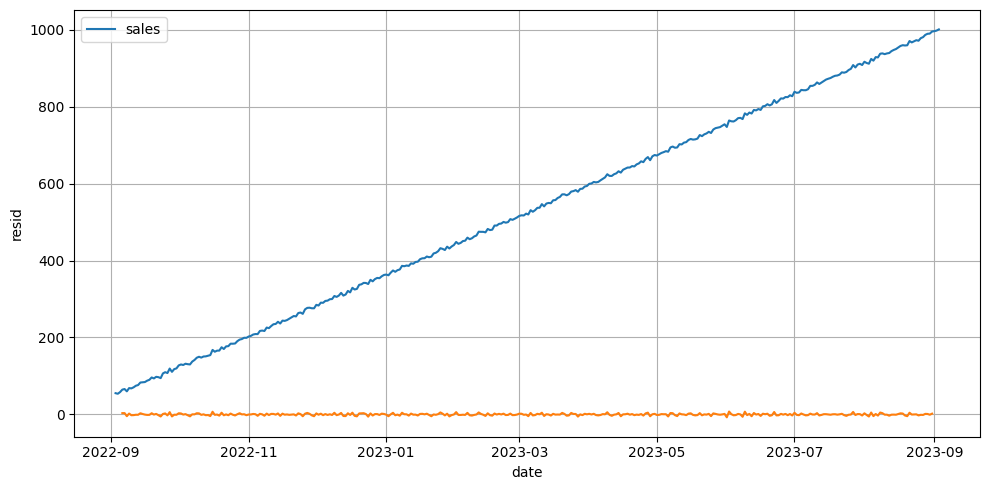

In [33]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot( data = data)
sns.lineplot(data = residual)
plt.tight_layout()
plt.grid()
plt.show()

Los residuos quedan flotando alrededor de 0. Eso significa que, una vez quitada la tendencia, solo queda ruido aleatorio muy pequeño. No hay patrones ocultos ni cambios raros: la serie es súper predecible

## Análisis de la autocorrelación

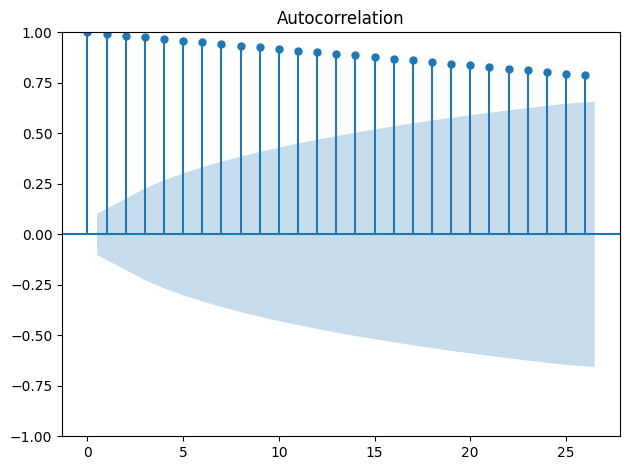

In [34]:
plot_acf(data)

plt.tight_layout()
plt.show()

La ACF cae muy lentamente desde 1.0 hacia abajo. Esto es típico de series con tendencia fuerte y confirma que la serie no es estacionaria

## Entrenamiento del modelo

In [35]:
model = auto_arima(ts, seasonal = False, trace = True, m = 7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.903 seconds


In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Tue, 09 Dec 2025   AIC                           1839.552
Time:                        13:52:22   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediccion

In [37]:
forecast = model.predict(30)
forecast

2023-09-04    1002.158148
2023-09-05    1004.831668
2023-09-06    1007.423289
2023-09-07    1010.021630
2023-09-08    1012.619419
2023-09-09    1015.217253
2023-09-10    1017.815084
2023-09-11    1020.412915
2023-09-12    1023.010746
2023-09-13    1025.608577
2023-09-14    1028.206408
2023-09-15    1030.804239
2023-09-16    1033.402071
2023-09-17    1035.999902
2023-09-18    1038.597733
2023-09-19    1041.195564
2023-09-20    1043.793395
2023-09-21    1046.391226
2023-09-22    1048.989057
2023-09-23    1051.586888
2023-09-24    1054.184719
2023-09-25    1056.782550
2023-09-26    1059.380381
2023-09-27    1061.978212
2023-09-28    1064.576043
2023-09-29    1067.173874
2023-09-30    1069.771705
2023-10-01    1072.369536
2023-10-02    1074.967367
2023-10-03    1077.565198
Freq: D, dtype: float64

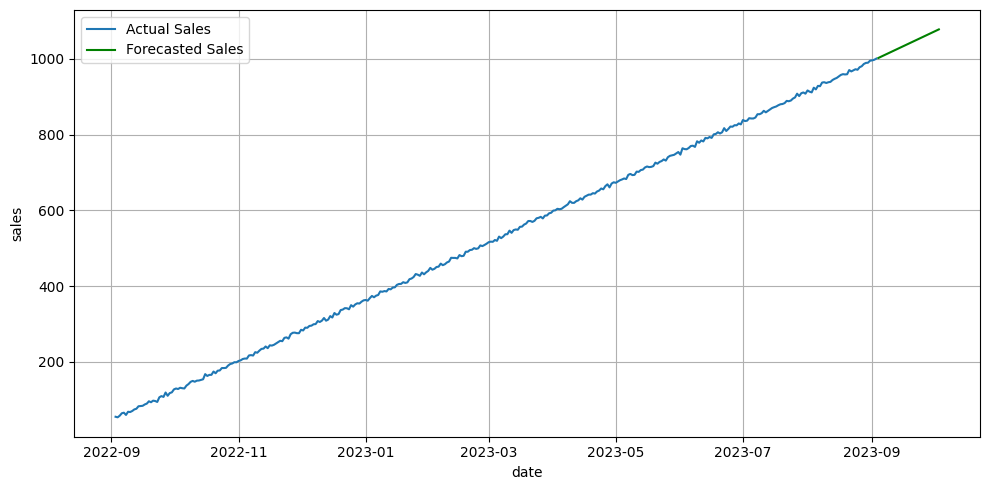

In [38]:
fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot(data=data, x=data.index, y='sales', ax=axis, label='Actual Sales')
sns.lineplot(data=forecast, c="green", ax=axis, label='Forecasted Sales')
plt.tight_layout()
plt.grid()
plt.show()

La línea verde (predicción) sigue muy bien el final de la línea azul (ventas reales). Esto muestra que el modelo ARIMA capta la tendencia y predice casi perfecto para los últimos días. Buen ajuste para una serie tan lineal.